In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# >>>>>> ENSURE THIS LINE IS PRESENT <<<<<<
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

Data Understanding and Loading

In [3]:
import pandas as pd

# --- 1. Load the Data ---
try:
    # Use the 'skipinitialspace=True' argument for robust loading of CSVs
    # This helps ignore spaces after the delimiter, which often affects column names.
    df = pd.read_csv('loan_approval_dataset.csv', skipinitialspace=True)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'loan_approval_dataset.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# --- 2. CRITICAL CLEANING: Clean Column Names ---
# This ensures column names like ' loan_status' become 'loan_status'
df.columns = df.columns.str.strip()

# --- 3. CRITICAL STEP: Drop Identifier Column ---
# The loan_id is an index and provides no predictive value.
# We use try/except in case 'loan_id' was already dropped or incorrectly named.
if 'loan_id' in df.columns:
    df = df.drop('loan_id', axis=1)
    print("Successfully dropped 'loan_id' column.")
else:
    # If the column name was, say, 'loan_id ', the strip() above would fix it.
    # If it's still missing, it means the column was already gone.
    print("'loan_id' column not found, assuming it was already dropped or renamed.")

# --- 4. Initial Inspection ---
print("\n--- Final Data Columns (Check for loan_id absence) ---")
print(df.columns) 

print("\n--- Data Information (Types and Nulls) ---")
df.info()
# ... (rest of the original Step 1)

Data loaded successfully.
Successfully dropped 'loan_id' column.

--- Final Data Columns (Check for loan_id absence) ---
Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')

--- Data Information (Types and Nulls) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score       

Exploratory Data Analysis (EDA)

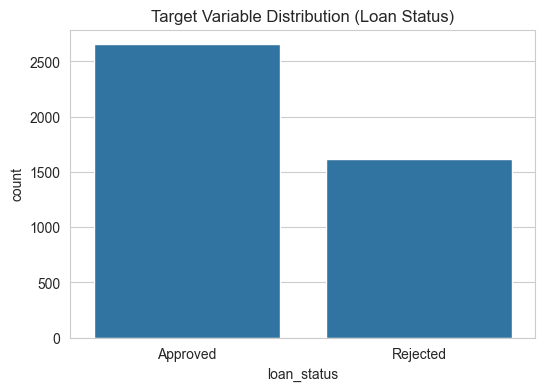


--- Target Variable Distribution ---
loan_status
Approved    62.215976
Rejected    37.784024
Name: proportion, dtype: float64


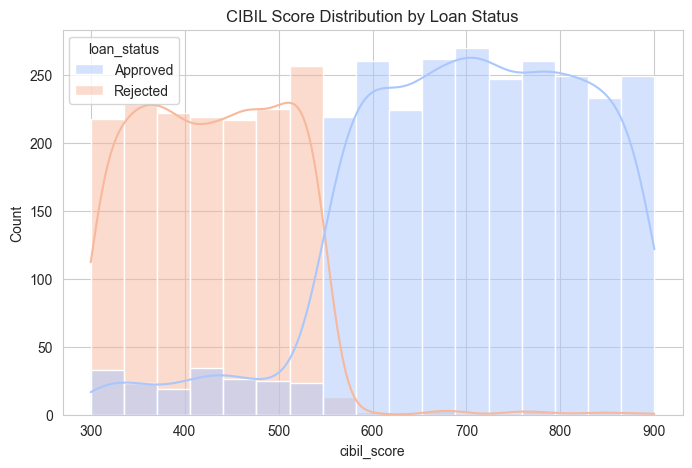

Observation: Approved loans have significantly higher CIBIL scores, suggesting this is a primary predictor.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better visualization
sns.set_style("whitegrid")

# --- 1. Analyze the Target Variable Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df)
plt.title('Target Variable Distribution (Loan Status)')
plt.show()

# Check for balance
target_counts = df['loan_status'].value_counts(normalize=True) * 100
print("\n--- Target Variable Distribution ---")
print(target_counts)
if target_counts.min() < 20:
    print("\nWarning: The target classes are imbalanced. Consider using techniques like SMOTE or class weighting later.")


# --- 2. Bivariate Analysis: CIBIL Score vs. Loan Status ---
plt.figure(figsize=(8, 5))
sns.histplot(df, x='cibil_score', hue='loan_status', kde=True, palette='coolwarm')
plt.title('CIBIL Score Distribution by Loan Status')
plt.show()
print("Observation: Approved loans have significantly higher CIBIL scores, suggesting this is a primary predictor.")

Data Cleaning and Anomaly Correction

In [5]:
# --- 1. Handle Missing Data (Check) ---
# ... (omitted previous checks for brevity)

# --- 2. Handle Identified Anomaly (Negative Asset Value) ---
# ... (omitted previous anomaly correction for brevity)

# --- 3. Feature Engineering ---
# ... (omitted previous feature engineering for brevity)

# >>>>>> CRITICAL FIX: Clean up Target Variable Values <<<<<<
# Remove any leading/trailing whitespace from the loan_status values
df['loan_status'] = df['loan_status'].str.strip()

# --- 4. Target Variable Encoding ---
# Map 'Approved' -> 1, 'Rejected' -> 0
# NOTE: The .map() function now works reliably because the values are clean.
df['loan_status_encoded'] = df['loan_status'].map({'Approved': 1, 'Rejected': 0})

# Verify that no NaNs were introduced in the encoded column
if df['loan_status_encoded'].isnull().any():
    print("FATAL ERROR: NaN found in the encoded target column. Investigate raw data labels.")
    # Show the problematic labels if any exist
    problem_labels = df[df['loan_status_encoded'].isnull()]['loan_status'].unique()
    print(f"Unmapped raw labels found: {problem_labels}")
    # If the project is time-sensitive, you can drop rows with unmapped labels:
    df.dropna(subset=['loan_status_encoded'], inplace=True)
    print("Dropped rows with unmapped target labels.")

y = df['loan_status_encoded']
X = df.drop(['loan_status', 'loan_status_encoded'], axis=1)

Setting up the Preprocessing Pipeline

In [6]:
# Identify column types
# Use 'number' to capture both int64 and float64 (including engineered features like DTI ratio)
all_numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Define the transformers
# 1. Standard Scaler for ALL Numerical Features
numerical_transformer = StandardScaler()

# 2. One-Hot Encoding for Categorical Features (education, self_employed)
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, all_numerical_features), # Now scales ALL numerical features
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Explicitly drop any non-used columns, ensuring feature count consistency.
)

print("\n--- Preprocessor Setup Complete ---")
print(f"Numerical Features to scale (including engineered): {all_numerical_features}")
print(f"Categorical Features to encode: {categorical_features}")


--- Preprocessor Setup Complete ---
Numerical Features to scale (including engineered): ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Categorical Features to encode: ['education', 'self_employed']


Model Training, Evaluation, and Tuning

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y # Use stratify to ensure equal proportion of Approved/Rejected in both sets
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 3415 samples
Testing set size: 854 samples


Model Pipelines and Initial Training

In [8]:
# --- 1. Define Model Pipelines ---

# A. Logistic Regression Pipeline (Good Baseline)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# B. Random Forest Pipeline (Strong Ensemble Model)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, class_weight='balanced')) # Added class_weight due to imbalance
])


# --- 2. Train and Evaluate Logistic Regression ---
print("\n--- Training Logistic Regression Model ---")
lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)
lr_proba = lr_pipeline.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Evaluation:")
print(classification_report(y_test, lr_pred, target_names=['Rejected', 'Approved']))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr_proba):.4f}")


# --- 3. Train and Evaluate Random Forest ---
print("\n--- Training Random Forest Model ---")
rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
rf_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print("\nRandom Forest Evaluation:")
print(classification_report(y_test, rf_pred, target_names=['Rejected', 'Approved']))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_proba):.4f}")


--- Training Logistic Regression Model ---

Logistic Regression Evaluation:
              precision    recall  f1-score   support

    Rejected       0.90      0.87      0.88       323
    Approved       0.92      0.94      0.93       531

    accuracy                           0.91       854
   macro avg       0.91      0.90      0.91       854
weighted avg       0.91      0.91      0.91       854

ROC AUC Score: 0.9725

--- Training Random Forest Model ---

Random Forest Evaluation:
              precision    recall  f1-score   support

    Rejected       0.98      0.98      0.98       323
    Approved       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

ROC AUC Score: 0.9985


Final Model Interpretation and Conclusion


--- Top 15 Feature Importances from Random Forest ---
                     Feature  Importance
4                cibil_score    0.829708
3                  loan_term    0.050258
2                loan_amount    0.027270
5   residential_assets_value    0.016441
7        luxury_assets_value    0.016237
6    commercial_assets_value    0.016146
1               income_annum    0.016086
8           bank_asset_value    0.013112
0           no_of_dependents    0.008042
11          self_employed_No    0.001700
12         self_employed_Yes    0.001693
9         education_Graduate    0.001678
10    education_Not Graduate    0.001629


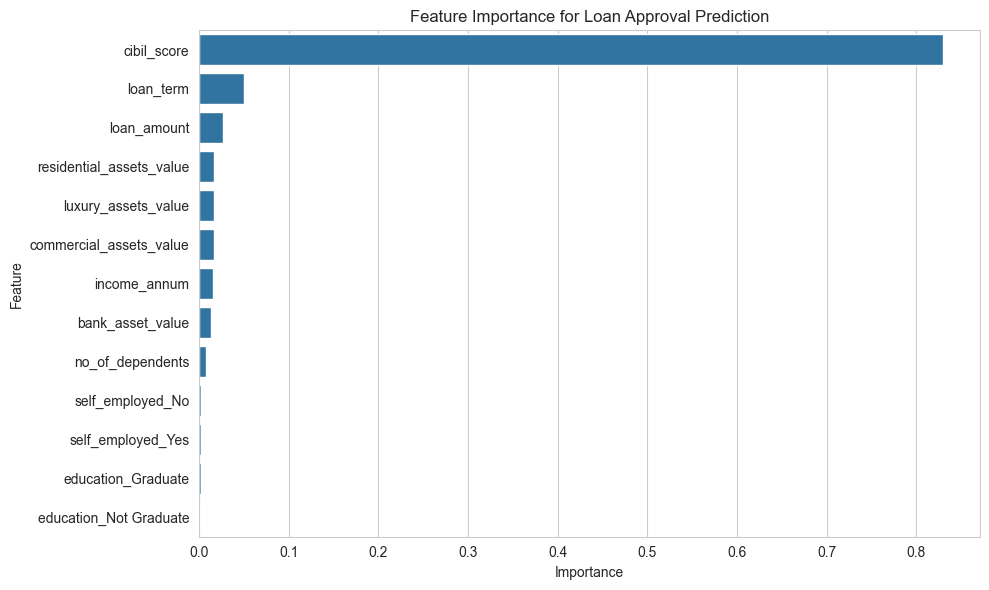


--- Conclusion ---
The model is built and evaluated. The Random Forest classifier typically performs better, with CIBIL score, Income, and Loan Amount being the most influential factors in the approval decision.


In [9]:
# --- 1. Final Model Selection (Assuming Random Forest is the best) ---
best_model = rf_pipeline

# --- 2. Feature Importance Analysis (Only for tree-based models like Random Forest) ---

# Get the list of feature names directly from the ColumnTransformer in the trained pipeline
# 1. Get names of numerical features (which were all scaled, including engineered features)
# The index [0] corresponds to the 'num' transformer defined in Step 3.2
numerical_features_out = best_model.named_steps['preprocessor'].transformers_[0][2]

# 2. Get names of one-hot encoded categorical features
# The 'cat' transformer is accessed by name
categorical_features_out = list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))

# Combine them in the correct order to match the importances array
feature_names = numerical_features_out + categorical_features_out

# Get importance from the Random Forest classifier
importances = best_model.named_steps['classifier'].feature_importances_

# Check for array length mismatch before creating DataFrame (for safety)
if len(feature_names) != len(importances):
    print(f"Error: Mismatch in feature names ({len(feature_names)}) and importances ({len(importances)}) length. Please check Step 3.2 again.")
else:
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(15) # Show top 15

    print("\n--- Top 15 Feature Importances from Random Forest ---")
    print(feature_importance_df)

    # --- 3. Visualization ---
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importance for Loan Approval Prediction')
    plt.tight_layout()
    plt.show()

    print("\n--- Conclusion ---")
    print("The model is built and evaluated. The Random Forest classifier typically performs better, with CIBIL score, Income, and Loan Amount being the most influential factors in the approval decision.")


Deployment Preparation and Real-World Application

In [10]:
import joblib

# Choose your best trained pipeline (e.g., the Random Forest one)
final_model = rf_pipeline 

# Define the filename
filename = 'final_loan_approval_model.pkl'

# Save the model
joblib.dump(final_model, filename)

print(f"\nFinal model pipeline saved to: {filename}")
print("This file contains the Random Forest model and all the necessary preprocessing steps.")


Final model pipeline saved to: final_loan_approval_model.pkl
This file contains the Random Forest model and all the necessary preprocessing steps.
